In [1]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from TCN_jordan import *
from hampel import hampel

In [5]:
data_set = pd.read_csv(r'/Users/jordan/Documents/MVA/ML_TS_2023/Projet/STA-TSN/Dataset/burnett-river-2014_.csv')

In [10]:
try:
    data_set= data_set.drop(0)
except:
    pass

In [11]:
def calculate_nan_percentage(dataframe):
    # Count the number of NaN values in each column
    nan_counts = dataframe.isna().sum()

    # Calculate the percentage of NaN values in each column
    nan_percentage = (nan_counts / len(dataframe)) * 100

    return nan_percentage
calculate_nan_percentage(data_set)

Timestamp                     0.000000
Chloraphylla ugL              0.274404
Chloraphylla ugL [Quality]    0.274404
DO mg                         0.157637
DO mg [Quality]               0.157637
DO Sat                        0.157637
DO Sat [Quality]              0.157637
EC mScm                       1.074264
EC mScm [Quality]             1.074264
pH                            0.157637
pH [Quality]                  0.157637
Temp degC                     0.531294
Temp degC [Quality]           0.531294
Turbidity NTU                 7.344699
Turbidity NTU [Quality]       7.344699
dtype: float64

In [13]:
col_to_drop=[col for col in data_set.columns if 'Quality' in col or 'Timestamp' in col]

In [14]:
nan_dataset=calculate_nan_percentage(data_set)

# data_set=data_set.drop(columns='NMHC(GT)')
data_set=data_set.drop(columns=list(nan_dataset[nan_dataset>40].index),axis=1) 

try:
    data_set=data_set.drop(columns=col_to_drop)
except:
    pass

data_set= data_set.fillna(data_set.median())

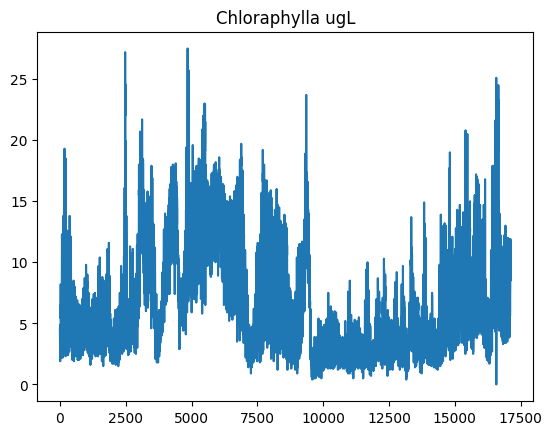

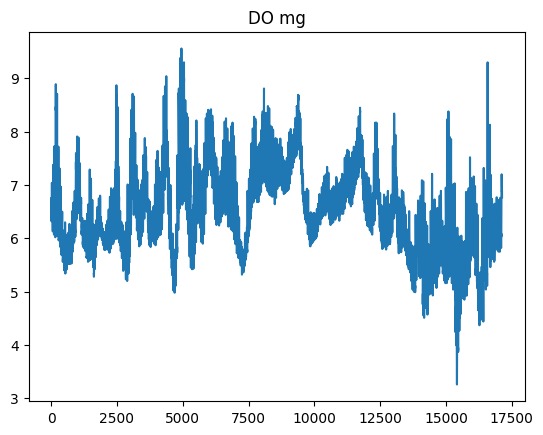

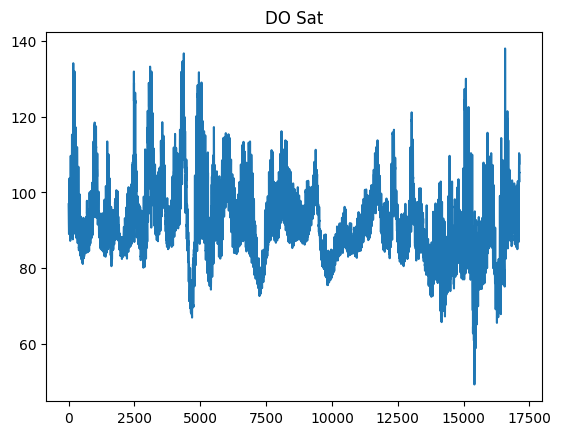

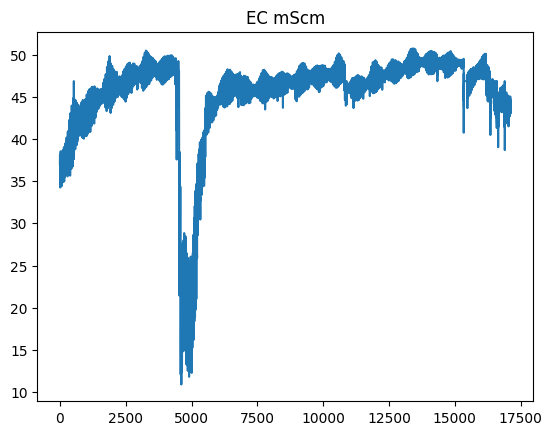

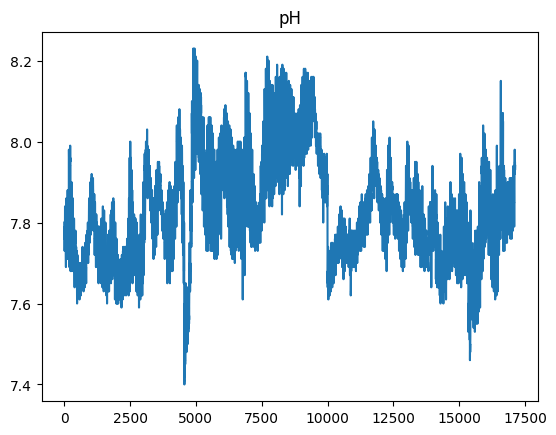

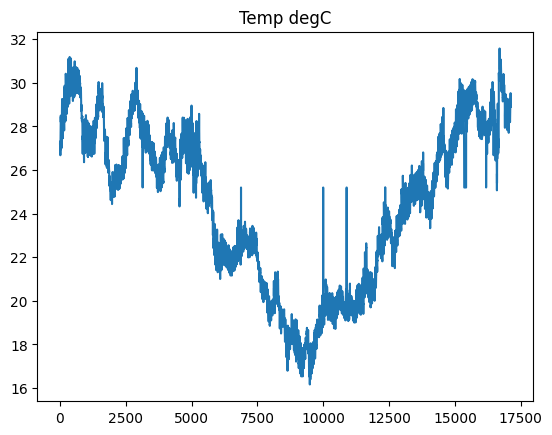

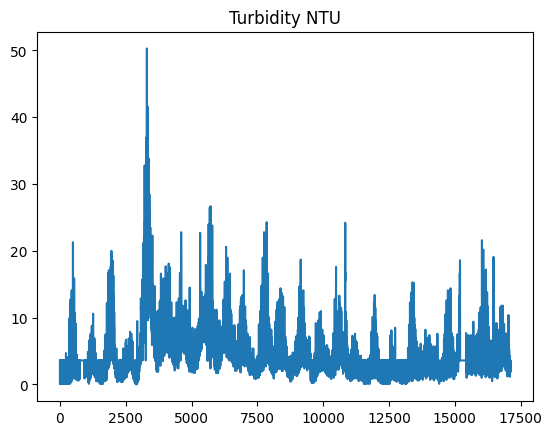

In [15]:
for col in data_set.columns:
        data_set[col].plot()#marker='.', linestyle='', markersize=10)
        plt.title(col)
        plt.show()

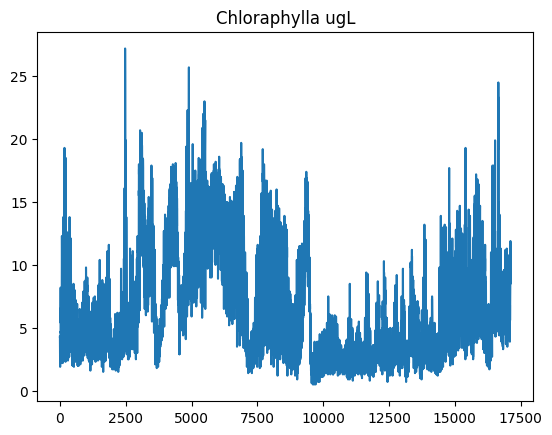

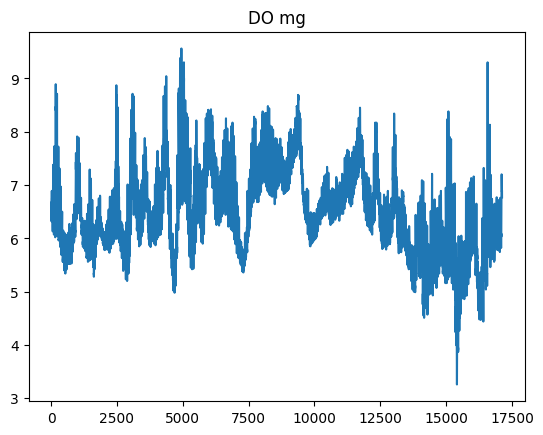

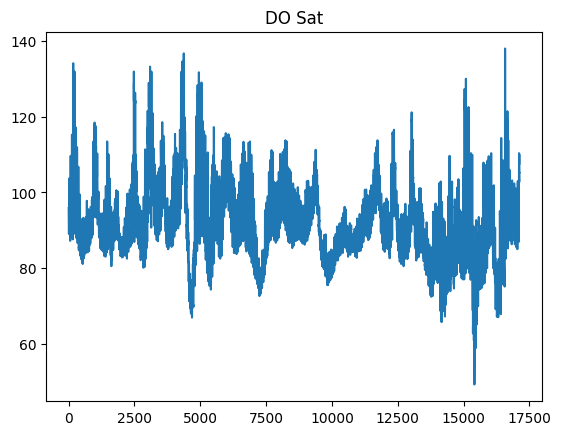

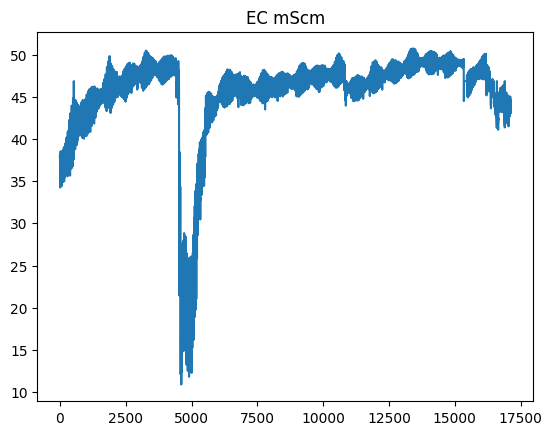

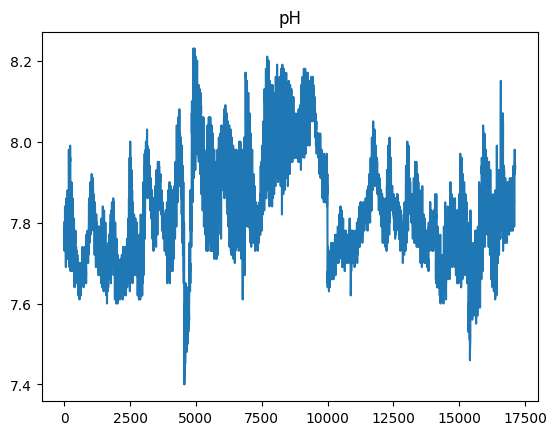

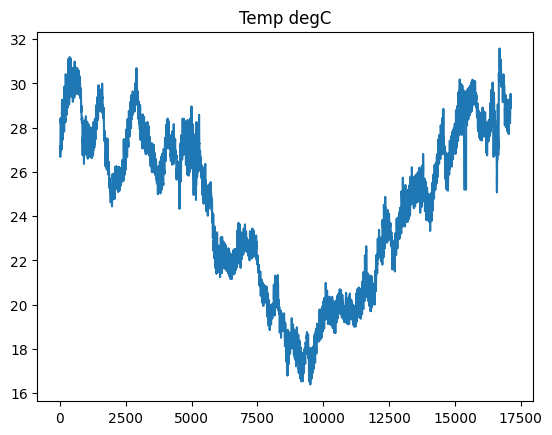

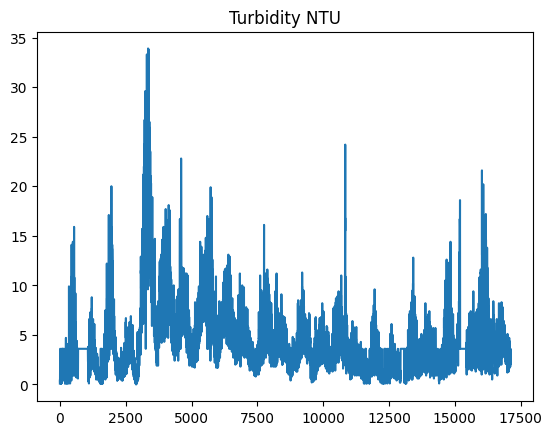

In [17]:
for col in data_set.columns:
    data_set[col]=hampel(data_set[col],window_size=20).filtered_data
    data_set[col].plot()
    plt.title(col)
    plt.show()

In [19]:
data_set= data_set.ewm(alpha=0.02, adjust=False).mean()
# data_set.ewm(alpha=0.02, adjust=False).mean()

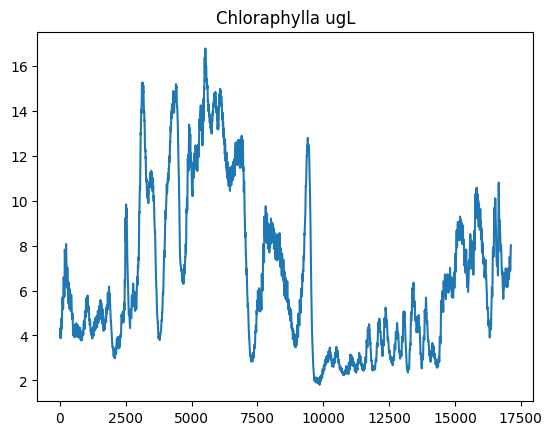

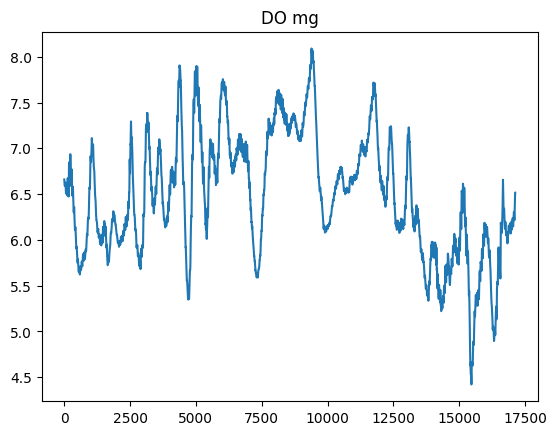

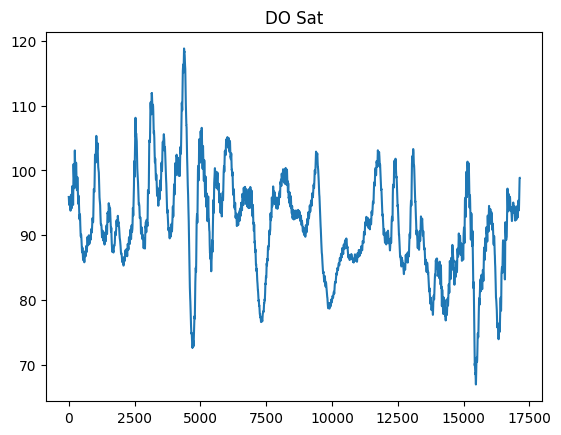

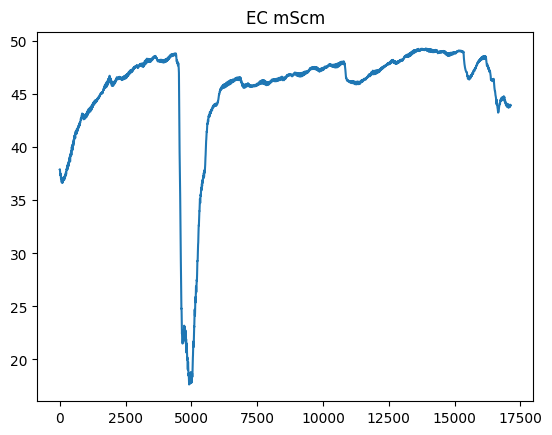

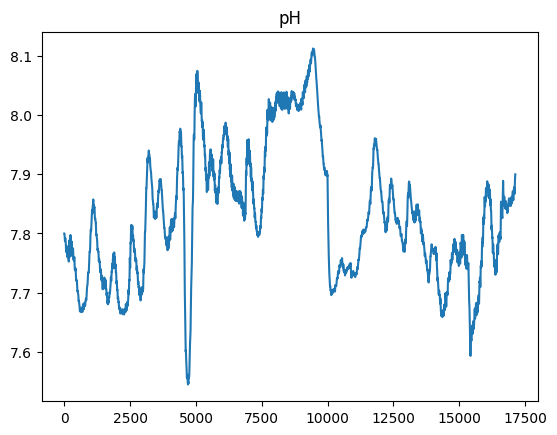

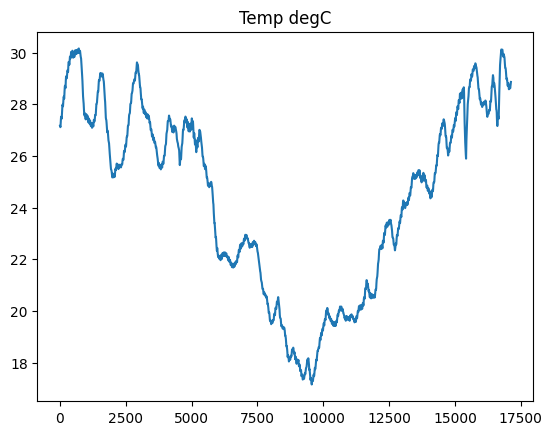

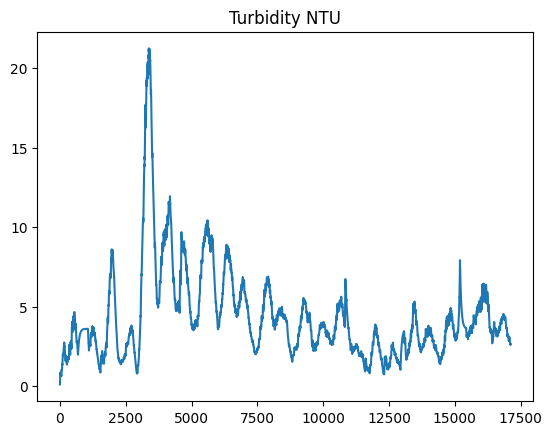

In [20]:
for col in data_set.columns:
    data_set[col].plot()
    plt.title(col)
    plt.show()

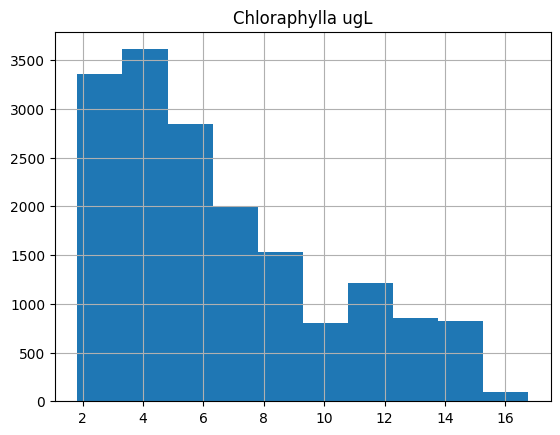

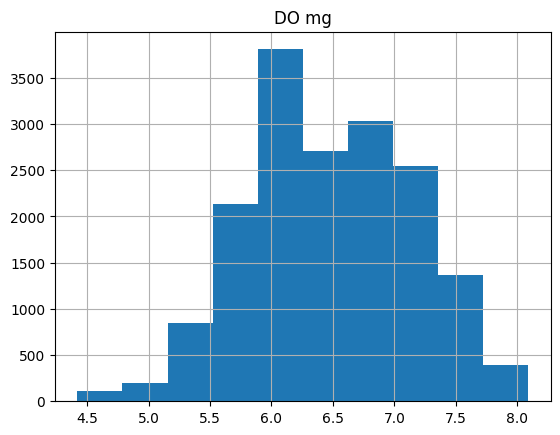

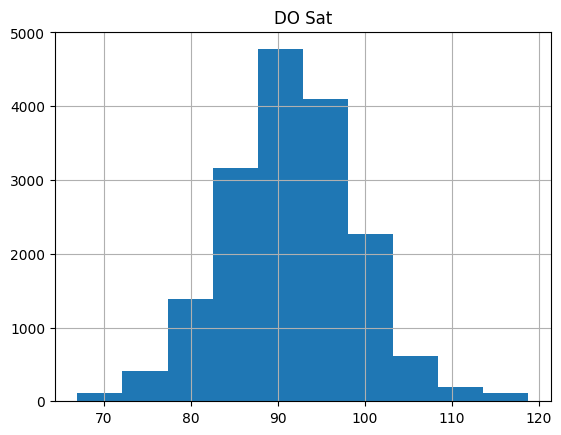

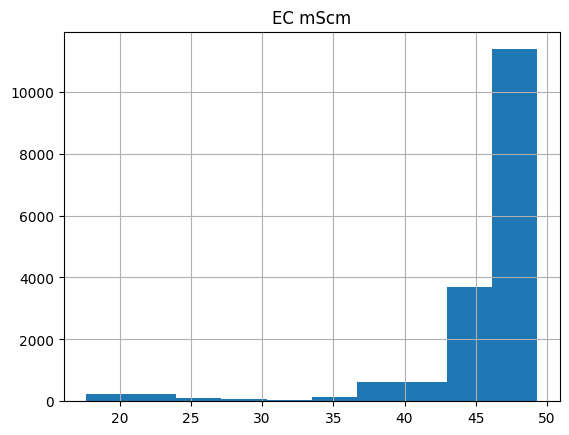

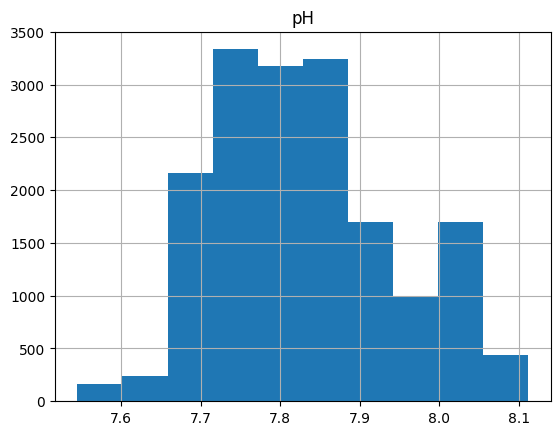

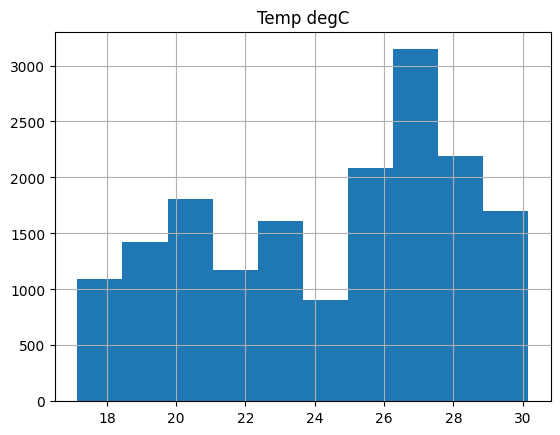

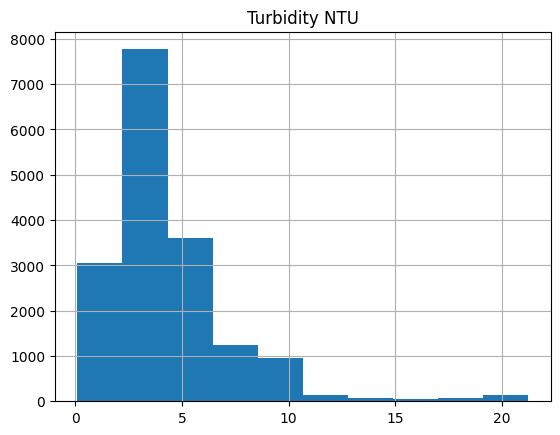

In [21]:
for col in data_set.columns:
        data_set[col].hist()
        plt.title(col)
        plt.show()

In [22]:
# standard scale the data
data_set=(data_set-data_set.mean())/data_set.std()

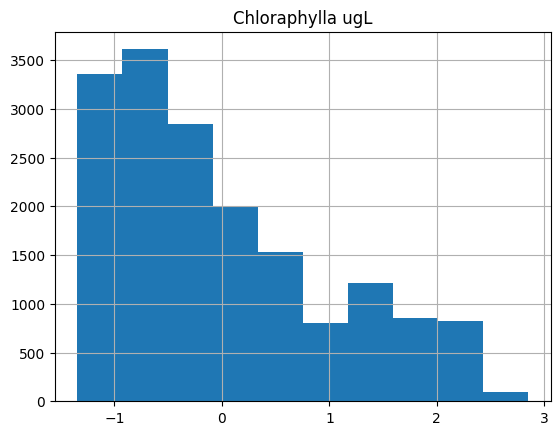

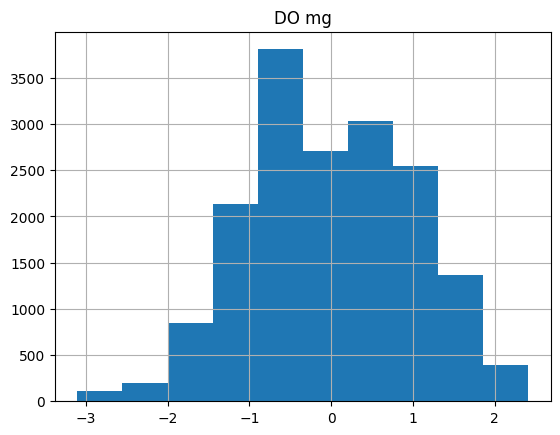

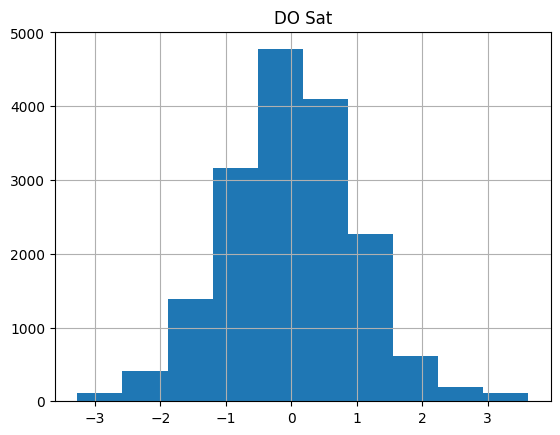

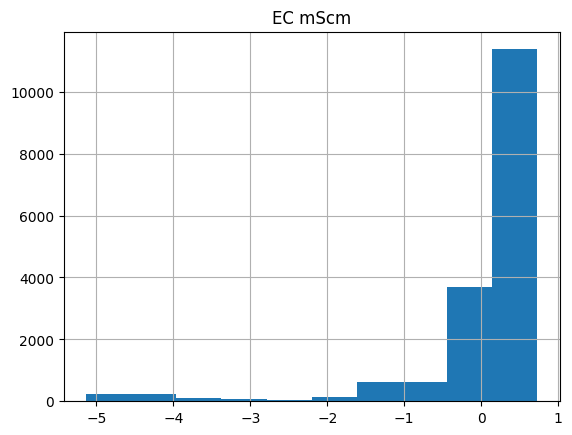

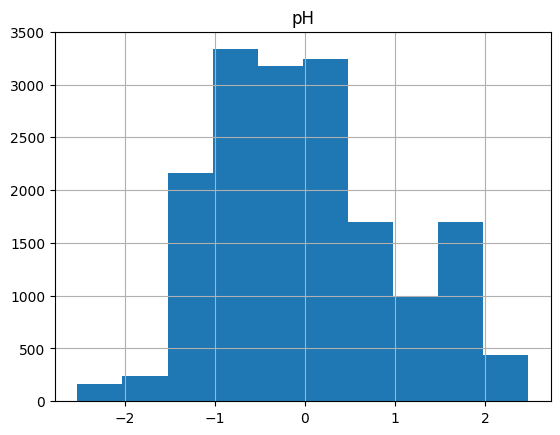

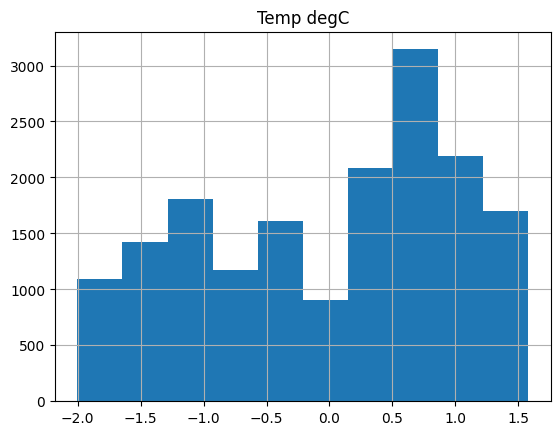

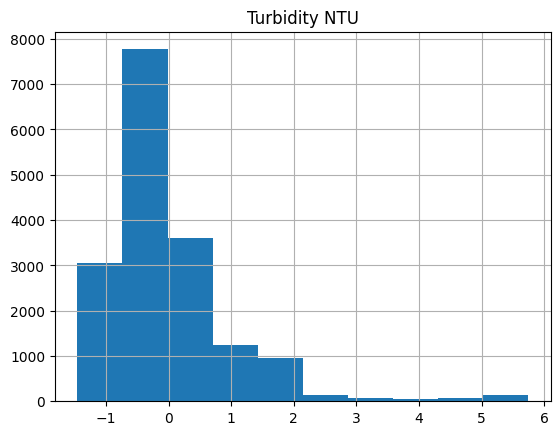

In [23]:
for col in data_set.columns:
        data_set[col].hist()
        plt.title(col)
        plt.show()

In [27]:
data_set= data_set[['Temp degC','Chloraphylla ugL', 'DO mg', 'DO Sat', 'EC mScm', 'pH',
       'Turbidity NTU']]

In [28]:
# data_set = pd.read_csv(r'Dataset/exchange_rate.csv')
train_val_data = data_set[: int(0.95 * len(data_set))]

validation_data = train_val_data[int(0.8 * len(train_val_data)):].copy()
train_data = train_val_data[: int(0.8 * len(train_val_data))]

test_data = data_set[int(0.95 * len(data_set)):]

In [29]:
def objective(trial):

    try:

        # Instantiate your ElectricNet model with the sampled hyperparameters
        window_size = trial.suggest_int('window_size', 10, 30)
        kernel_size = 2*trial.suggest_int('kernel_size', 3, 5)+1
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 3, 10)
        n_hidden_dimensions = trial.suggest_int('n_hidden_dimensions', 1, 10)
        
        # n_signals = trial.suggest_int('n_signals', 1, 10)
        prediction_horizon = 2 #trial.suggest_int('prediction_horizon', 1, 2)
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        batch_size = trial.suggest_int('batch_size', 64, 128)
        
        patience = 50 #trial.suggest_int('patience', 10, 30)
        conv_dilatation = trial.suggest_int('conv_dilatation', 1, 3)
        n_signals=7
        
        # TODO : - Conv dilation il l'a enforcé à 1 - kernel size est obligé d'être impair à cause de comment il set le padding - les index à prendre ca doit etre dim_points_df-prediction_horizon+1 - revoir la relation windows size et training - check l'architecture
        
        
        nb_epochs = 200#
        
        seed= trial.suggest_int('seed', 50, 200)
        number_TCN= trial.suggest_int('number_TCN', 3, 7)
        # Create an instance of the PSTA_TCN model with the sampled hyperparameters
        model = PSTA_TCN(
            window_size=window_size,
            kernel_size=kernel_size,
            n_hidden_layers=n_hidden_layers,
            n_hidden_dimensions=n_hidden_dimensions,
            n_signals=n_signals,
            prediction_horizon=prediction_horizon,
            lr=lr,
            dropout_rate=dropout_rate,
            batch_size=batch_size,
            nb_epochs=nb_epochs,
            patience=patience,
            conv_dilatation=conv_dilatation,
            seed=seed,
            number_TCN=number_TCN,
            
        )

        model.fit(train_data, validation_data)

        points=predict_fn(model,data_set)
        df_points=pd.DataFrame(points.detach().numpy())
        df_points[0]=df_points[0].astype('int')
        df_points= df_points.groupby(0).mean()
        
        plt.scatter(x=points[:,0],y=points[:,1],label='predicted_points')
        data_set.iloc[:,0].plot(label='real_curve',color='red')
        plt.title('prediction_'+str(model.seed))
        plt.axvline(x=int(0.95 * len(data_set)), color='green', linestyle='--', label=f'Vertical Line at x={int(0.95 * len(data_set))}')
        plt.legend()
        plt.show()
        
        return -np.corrcoef(data_set.iloc[df_points.index-prediction_horizon+1,0].values.flatten(),df_points.values.flatten())[0,1]



    except Exception as e:
        raise optuna.exceptions.TrialPruned(f'Skipping this trial due to an error: {str(e)}')
    


In [30]:
def run_optuna():

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50,n_jobs=3)
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")

    study.trials_dataframe().to_excel(r'/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/result_summary.xlsx')
    fig = optuna.visualization.plot_param_importances(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_params.png", format='png', engine='kaleido')
    fig = optuna.visualization.plot_optimization_history(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_history.png", format='png', engine='kaleido')


    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    best_num=list(study.trials_dataframe().sort_values(by='value', ascending=False)[:5]['number'])
    print(best_num)


In [ ]:
run_optuna()

[I 2023-12-18 22:05:32,390] A new study created in memory with name: no-name-47434d85-eb85-48a1-9235-8cc7c8626c02
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



In [31]:
def predict_fn(model,dataset):
        prediction_horizon=model.tau
        window_size=model.T 
        train_set = torch.from_numpy(dataset.astype('float32').values)
        train_data = [train_set[i: i + window_size] for i in range(len(train_set) - window_size)]
        point_to_plot=[]
        for i,x in enumerate(train_data):
                predictions=model.predict(x)
                point_to_plot+=[torch.Tensor([v,predictions.squeeze()[k]]) for k,v in enumerate(np.arange(i+window_size,i+window_size+prediction_horizon))]
        
        point_to_plot=torch.stack(point_to_plot)
        
        return point_to_plot
  

In [32]:
# rams: 
#     window_size: 19
#     kernel_size: 4
#     n_hidden_layers: 10
#     n_hidden_dimensions: 5
#     lr: 0.0002591332973344816
#     dropout_rate: 0.11272903542955753
#     batch_size: 107
#     seed: 151
#     number_TCN: 5
    
model_2= PSTA_TCN(
window_size=19,
kernel_size=9,
n_hidden_layers=10,
n_hidden_dimensions=5,
n_signals=7,
prediction_horizon=2,
batch_size=107,
lr=0.0002591332973344816,
nb_epochs=200,
number_TCN=5,
dropout_rate=0.11272903542955753,
seed=129,
patience=50,
)

model_2.fit(train_data,validation_data)

In [33]:
points=predict_fn(model_2,data_set)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


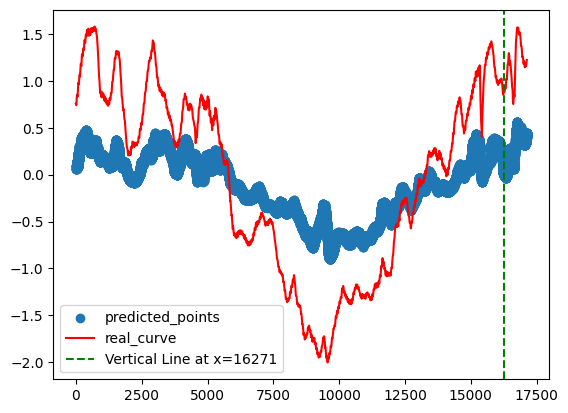

In [37]:
plt.scatter(x=points[:,0],y=points[:,1],label='predicted_points')
data_set.iloc[:,0].plot(label='real_curve',color='red')
plt.axvline(x=int(0.95 * len(data_set)), color='green', linestyle='--', label=f'Vertical Line at x={int(0.95 * len(data_set))}')
plt.legend()

In [141]:
# points=predict_fn(model,data_set,prediction_horizon,window_size=40)

In [142]:
# points=predict_fn(model,data_set,prediction_horizon,window_size=40)
df_points=pd.DataFrame(points.detach().numpy())
df_points[0]=df_points[0].astype('int')
df_points= df_points.groupby(0).mean()
np.linalg.norm(data_set.iloc[df_points.index-1,0].values.flatten()-df_points.values.flatten())

72.07399414504543

In [143]:
np.corrcoef(data_set.iloc[df_points.index-1,0].values.flatten(),df_points.values.flatten())[0,1]

0.571207030200063

16271